Implementing a multi layer perceptron on [Emnist dataset](https://www.tensorflow.org/datasets/catalog/emnist) using Pytorch.

A multilayer perceptron (MLP) or feed forward neural network has three layers:
1. Input Layer
2. Hidden Layer
3. Output Layer

Training task for Emnist Dataset: multi class classification

1. input is a flattened image from the emnist dataset
2. output is a probability distribution

***TLDR: Classify the image of a handwritten number or alphabet (52 alphabets + 10 numbers = 62 possible outcomes)***

**Example:**

Input - grayscale image of a handwritten letter or number (byclass variant), which is represented as a matrix. This matrix is flattened into a vector that is fed into the MLP

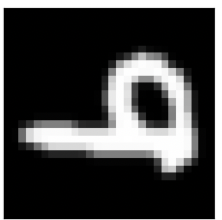

Output - The output is a vector where each value represents the model's predicted probability of the input image being of the respective class. The class with the highest probability is the model's prediction.

If the distribution is [0.1, 0.4, 0.2, 0.3, 0.7, ...., 0.8] and the highest probability distribution is 0.8, the class representing 0.8 (hopefully, 9 in this case) would be the model's classification.

****Important Definitions in the code:****

1. Softmax function to ensure the probability distribution is between 0 and 1. However, it is not used explicitly it is internally applied in cross entropy loss.

2. Cross Entropy Loss is commonly used for classification problems.
Formula -

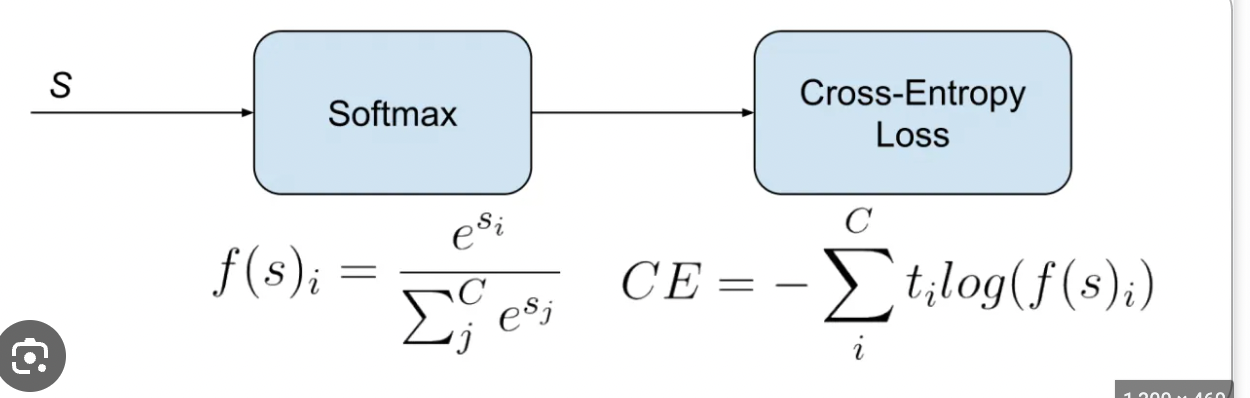

3. Adam optimization (or Adaptive Moment Estimation):
It is a learning rate optimization algorithm. In this code, the learning rate is 0.001. It converges very fast. Alterantively, we could have used SGD optimizer.

4. ReLU Activation (or Rectified Linear Unit):
It is a non linear activation function applied after the first and second fully connected layers, allowing the network to capture more complex relationships in the data. Especially, in image classification tasks, introducing non linearity is vital.

5. Regularization, overfitting, and dropout:
Overfitting occurs when a model is too complex and starts to memorize the training data rather than generalizing from it.
Regularization is a technique to prevent overfitting. The regularized model performs better on unseen (testing) data.
Dropout is a regularization technique. It randomly sets a fraction of inputs (in this code, 50%) to 0 at each update, ensuring that the model does not heavily rely on a single input.


**1. Importing Emnist Dataset and Pytorch Library**

In [ ]:
!pip install emnist
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from emnist import list_datasets, extract_training_samples, extract_test_samples

In [ ]:
print(list_datasets())

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


**Using the byclass variant**

In [ ]:
train_images, train_labels = extract_training_samples('byclass')
test_images, test_labels = extract_test_samples('byclass')

**2. Data Preprocessing**

In [ ]:
#Convert data to tensors/vectors to feed into MLP

train_images = torch.tensor(train_images, dtype=torch.float32).reshape(-1, 28*28) / 255.0
test_images = torch.tensor(test_images, dtype=torch.float32).reshape(-1, 28*28) / 255.0
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [ ]:
#Batching using Dataloader to make training efficient

train_data = torch.utils.data.TensorDataset(train_images, train_labels)
test_data = torch.utils.data.TensorDataset(test_images, test_labels)
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**3. MLP Model**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



**4. Training**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(28*28, 512, len(set(train_labels.numpy())))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")
    scheduler.step()

Epoch 1/40, Loss: 0.8046266861723123
Epoch 2/40, Loss: 0.6310716963581661
Epoch 3/40, Loss: 0.5910456460833484
Epoch 4/40, Loss: 0.5669855939430336
Epoch 5/40, Loss: 0.5520441975972641
Epoch 6/40, Loss: 0.5224541476313704
Epoch 7/40, Loss: 0.513434345620981
Epoch 8/40, Loss: 0.507016103988653
Epoch 9/40, Loss: 0.5019120639690495
Epoch 10/40, Loss: 0.4997973796803427
Epoch 11/40, Loss: 0.48998253913990797
Epoch 12/40, Loss: 0.48499391903882505
Epoch 13/40, Loss: 0.48240212548791256
Epoch 14/40, Loss: 0.48082449264905003
Epoch 15/40, Loss: 0.4780592449527256
Epoch 16/40, Loss: 0.4731280624855555
Epoch 17/40, Loss: 0.4727830214416699
Epoch 18/40, Loss: 0.4688980380193085
Epoch 19/40, Loss: 0.4691490060076809
Epoch 20/40, Loss: 0.46834976167202697
Epoch 21/40, Loss: 0.46634326535540943
Epoch 22/40, Loss: 0.4655095074929033
Epoch 23/40, Loss: 0.4645977771688815
Epoch 24/40, Loss: 0.4637708694382193
Epoch 25/40, Loss: 0.46369124310083965
Epoch 26/40, Loss: 0.46267761096601506
Epoch 27/40, Lo

**Testing**

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad(): #dont' have to update weights, so don't compute gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        max_value, predicted = torch.max(outputs.data, 1) #max value in the probablity distribution and it's corresponding index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total}%")


Accuracy on test set: 85.83083311125057%


**Example: Randomly generated**

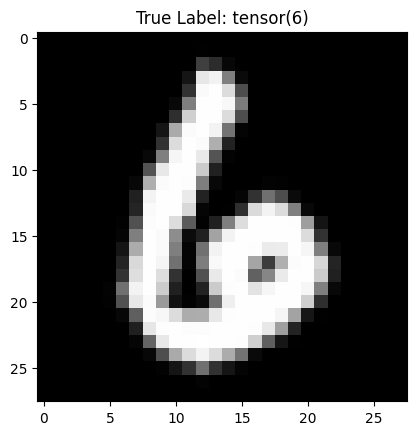

Predicted Label: 6


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def emnist_label_decoder(label):
    if 0 <= label <= 9: #numbers
        return str(label)
    elif 10 <= label <= 35:
        return chr(label - 10 + ord('A')) #uppercase alphabets
    elif 36 <= label <= 61:
        return chr(label - 36 + ord('a')) #lowercase alphabets

#Randomly selecting an image and its label
index = np.random.randint(len(test_images))
sample_image = test_images[index]
sample_label = test_labels[index]

#Image with its true label (display)
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title(f"True Label: {emnist_label_decoder(sample_label)}")
plt.show()

#Predictinf the label using the model
model.eval()
with torch.no_grad(): #no backprop
    input_image = sample_image.to(device).reshape(1, -1)
    output = model(input_image)
    _, prediction = torch.max(output.data, 1)

print(f"Predicted Label: {emnist_label_decoder(prediction.item())}")
